In [1]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import pickle
import pandas as pd
import os
import math
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import GridSearchCV
import pickle

<h2>Подготовка данных </h2>

In [2]:
# Данные можно скачать по ссылке: https://www.kaggle.com/datasets/rajyellow46/wine-quality
file_path = "winequalityN.csv"

data = pd.read_csv(file_path, parse_dates=True)

mix_data = data.sample(frac=1).reset_index(drop=True)
mix_data.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.1              0.30         0.49             1.6   
1    red            7.1              0.56         0.14             1.6   
2    red            9.8              0.30         0.39             1.7   
3  white            6.2              0.36         0.32             4.0   
4  white            7.1              0.24         0.34             1.2   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 31.0                 100.0  0.99420  3.40   
1      0.078                  7.0                  18.0  0.99592  3.27   
2      0.062                  3.0                   9.0  0.99480  3.14   
3      0.036                 44.0                  92.0  0.98936  3.20   
4      0.045                  6.0                 132.0  0.99132  3.16   

   sulphates  alcohol  quality  
0       0.59     10.2        5  
1       0.62      9.3        5  
2       0.57     11.5        7  
3       0.50     13.3        7  
4       0.46     11.2        4

In [3]:
names = ['type', 'fixed acidity','volatile acidity', 'citric acid',	'residual sugar', 'chlorides',	'free sulfur dioxide',	'total sulfur dioxide',	'density',	'pH', 'sulphates',	'alcohol', 'quality']
colors = ['#9932CCAF', '#98F5FFAF', '#FFD39BAF', '#8B2323AF', '#FF4040AF', '#0000FFAF', '#E3CF57AF', '#00FFFFAF', '#FF1493AF', '#228B22AF', '#7FFF00AF', '#8B0A50AF', '#5D478BAF']

data_without_miss = mix_data.dropna()

print(" len data: {}".format(len(data)))
print(" len data_without_miss: {}".format(len(data_without_miss)))

mix_data = data_without_miss

mix_data.describe()

 len data: 6497
 len data_without_miss: 6463


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6463.000000       6463.000000  6463.000000     6463.000000   
mean        7.217755          0.339589     0.318758        5.443958   
std         1.297913          0.164639     0.145252        4.756852   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6463.000000          6463.000000           6463.000000  6463.000000   
mean      0.056056            30.516865            115.694492     0.994698   
std       0.035076            17.758815             56.526736     0.003001   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992330   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.997000   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality  
count  6463.000000  6463.000000  6463.000000  6463.000000  
mean      3.218332     0.531150    10.492825     5.818505  
std       0.160650     0.148913     1.193128     0.873286  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.510000    10.300000     6.000000  
75%       3.320000     0.600000    11.300000     6.000000  
max       4.010000     2.000000    14.900000     9.000000

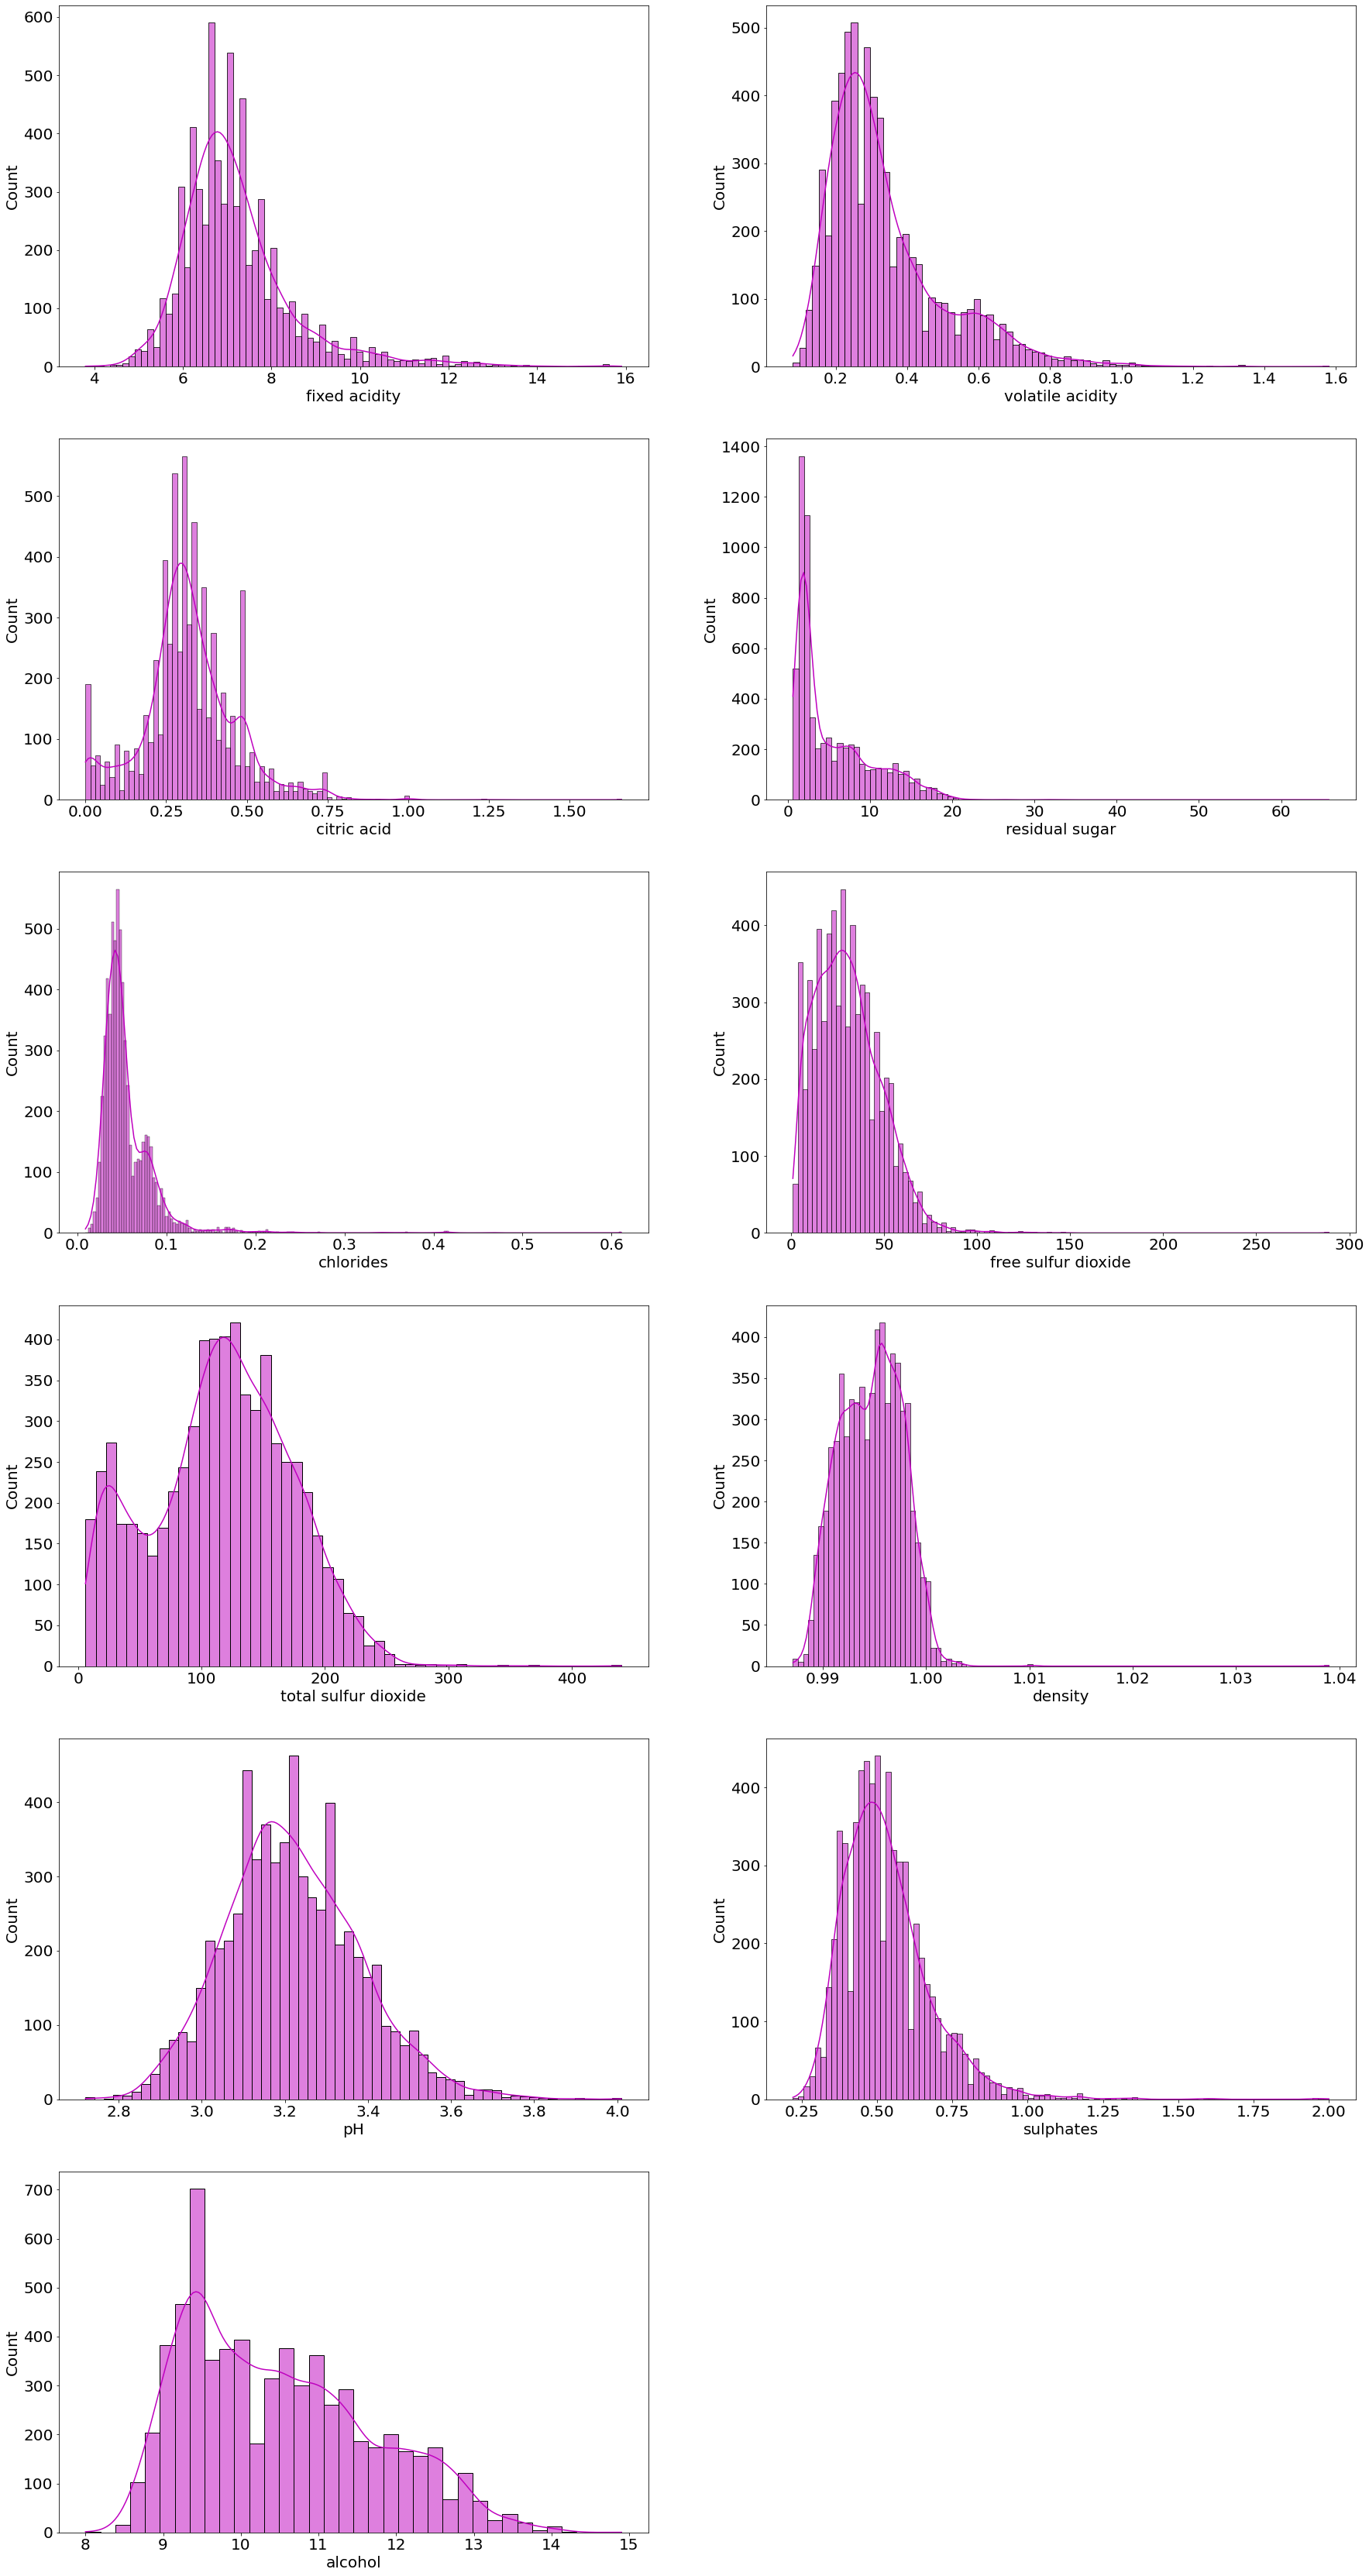

In [4]:
def plot_hist(data, names):
    plt.figure(figsize=(30, 60))
    plt.rc('legend', fontsize=30)  
    plt.rc('font', size=20)
    l = len(names)
    a = l // 2 + 1
    b = l // a + 1
    for i in range(l):
        x = plt.subplot(a, b, i + 1)
        val = data[names[i]]
        sns.histplot(val, kde = True, color="m")
        
plot_hist(data, names[1:len(names) - 1])

При анализе данных было выяснено, что присутствуют выбросы, их необходимо удалить:

In [5]:
data_IQR = mix_data
for i in range(1, len(names) - 1):
    qv1 =  mix_data[names[i]].quantile(0.2)
    qv2 = mix_data[names[i]].quantile(0.8)
    between = qv2 - qv1
    data_IQR = data_IQR.loc[(mix_data[names[i]] > (qv1 - 1.5 * between)) & (mix_data[names[i]] < (qv2 + 1.5 * between))]

data = data_IQR

print(" len data: {}".format(len(data)))
data.describe()

 len data: 5832


fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5832.000000       5832.000000  5832.000000     5832.000000   
mean        7.038915          0.324532     0.306049        5.571065   
std         0.970149          0.144369     0.125217        4.704210   
min         3.900000          0.080000     0.000000        0.600000   
25%         6.400000          0.220000     0.240000        1.800000   
50%         6.900000          0.280000     0.300000        3.300000   
75%         7.600000          0.390000     0.380000        8.300000   
max        10.200000          0.805000     0.700000       20.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5832.000000          5832.000000           5832.000000  5832.000000   
mean      0.050601            31.023748            119.183985     0.994448   
std       0.019410            16.458574             53.937559     0.002860   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.037000            18.000000             86.000000     0.992100   
50%       0.046000            29.000000            121.000000     0.994600   
75%       0.058000            42.000000            157.000000     0.996700   
max       0.127000            89.000000            303.000000     1.002600   

                pH    sulphates      alcohol      quality  
count  5832.000000  5832.000000  5832.000000  5832.000000  
mean      3.220108     0.515941    10.516012     5.844993  
std       0.156186     0.124616     1.200980     0.863509  
min       2.720000     0.220000     8.000000     3.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.500000    10.400000     6.000000  
75%       3.320000     0.590000    11.300000     6.000000  
max       3.750000     0.960000    14.200000     9.000000

Посмострим на матрицу корреляций:

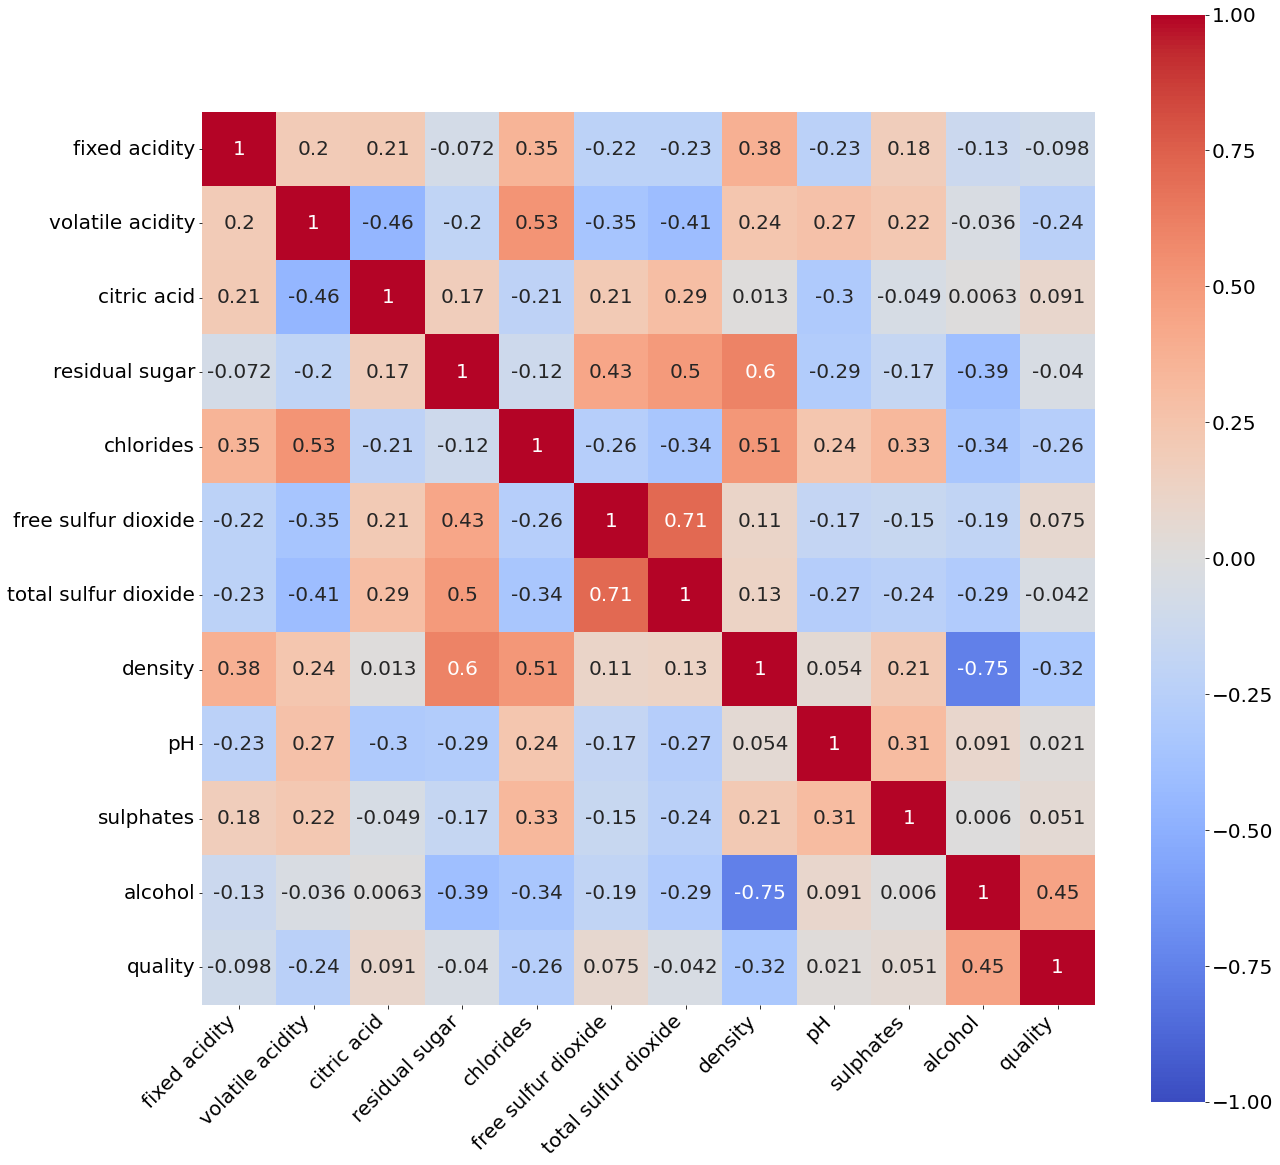

In [6]:
corr = data.corr()
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap= 'coolwarm', square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.show()

Удалим данные, мало влияющие на результат:

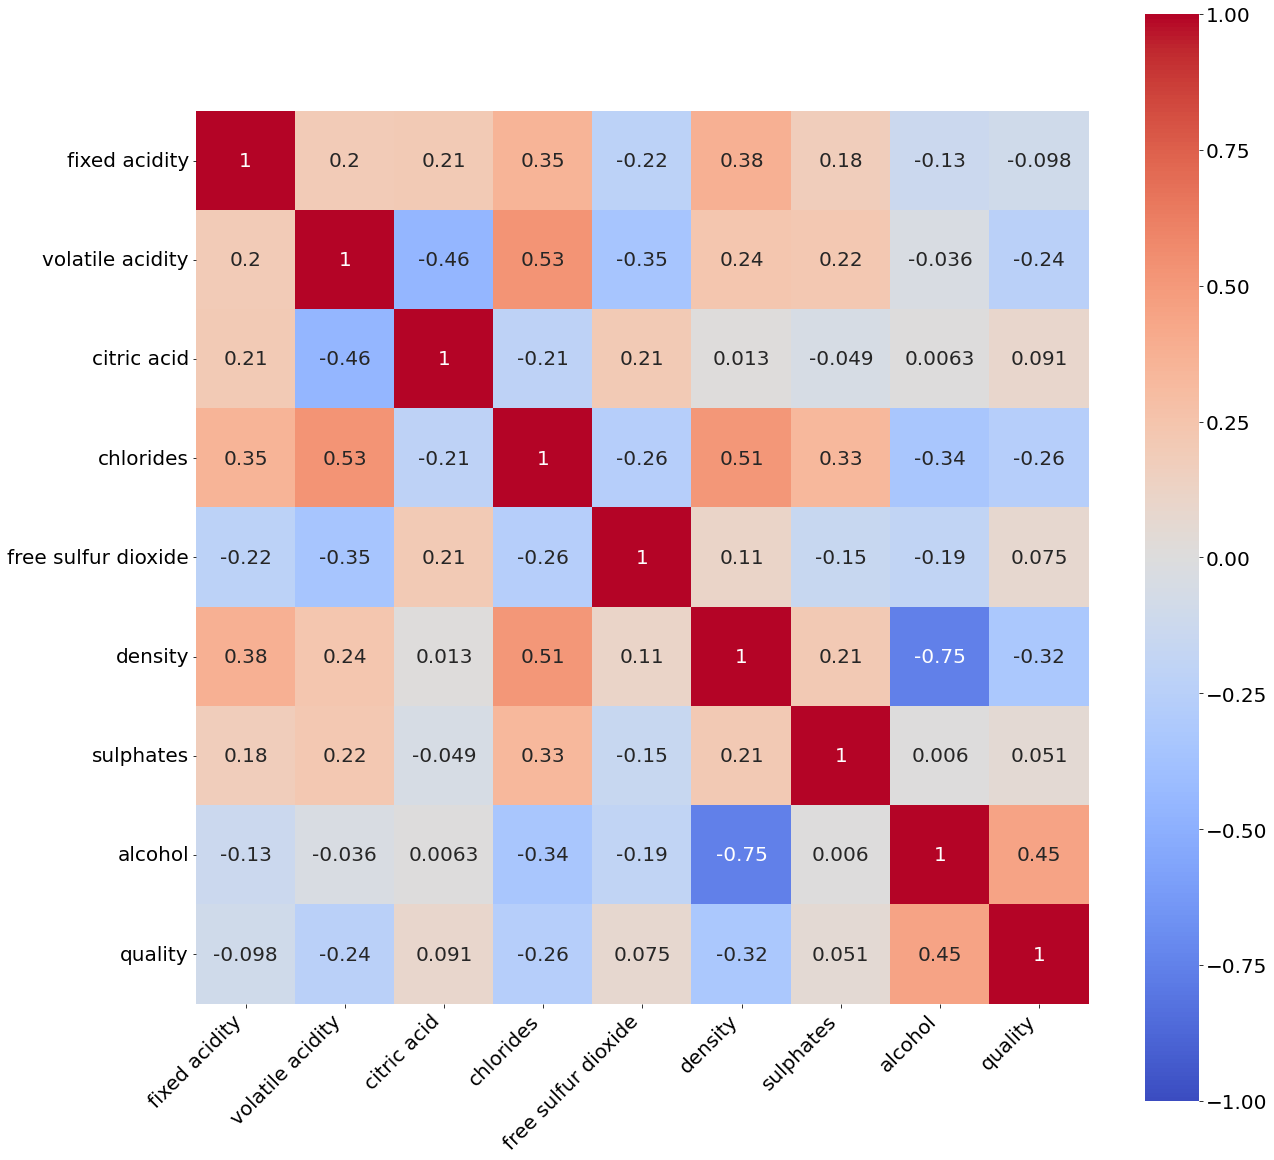

In [7]:
# data1 = data.drop(columns=["pH", "sulphates", "free sulfur dioxide", "total sulfur dioxide", "residual sugar", "citric acid", "fixed acidity", "density"])
data1 = data.drop(columns=["pH","residual sugar", "total sulfur dioxide"])

corr = data1.corr()
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, cmap= 'coolwarm', square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
plt.show()

In [8]:
data1.groupby("quality").size()

quality
3      13
4     176
5    1895
6    2556
7    1007
8     180
9       5
dtype: int64

In [9]:
cond01 = data1['quality'] == 3
cond02 = data1['quality'] == 4
cond03 = data1['quality'] == 5

cond12 = data1['quality'] == 6

cond21 = data1['quality'] == 7
cond22 = data1['quality'] == 8
cond23 = data1['quality'] == 9

data1.loc[cond01, 'quality'] = 0
data1.loc[cond02, 'quality'] = 0
data1.loc[cond03, 'quality'] = 0

data1.loc[cond12, 'quality'] = 1

data1.loc[cond21, 'quality'] = 2
data1.loc[cond22, 'quality'] = 2
data1.loc[cond23, 'quality'] = 2

print(data1.groupby("quality").size())

quality
0    2084
1    2556
2    1192
dtype: int64


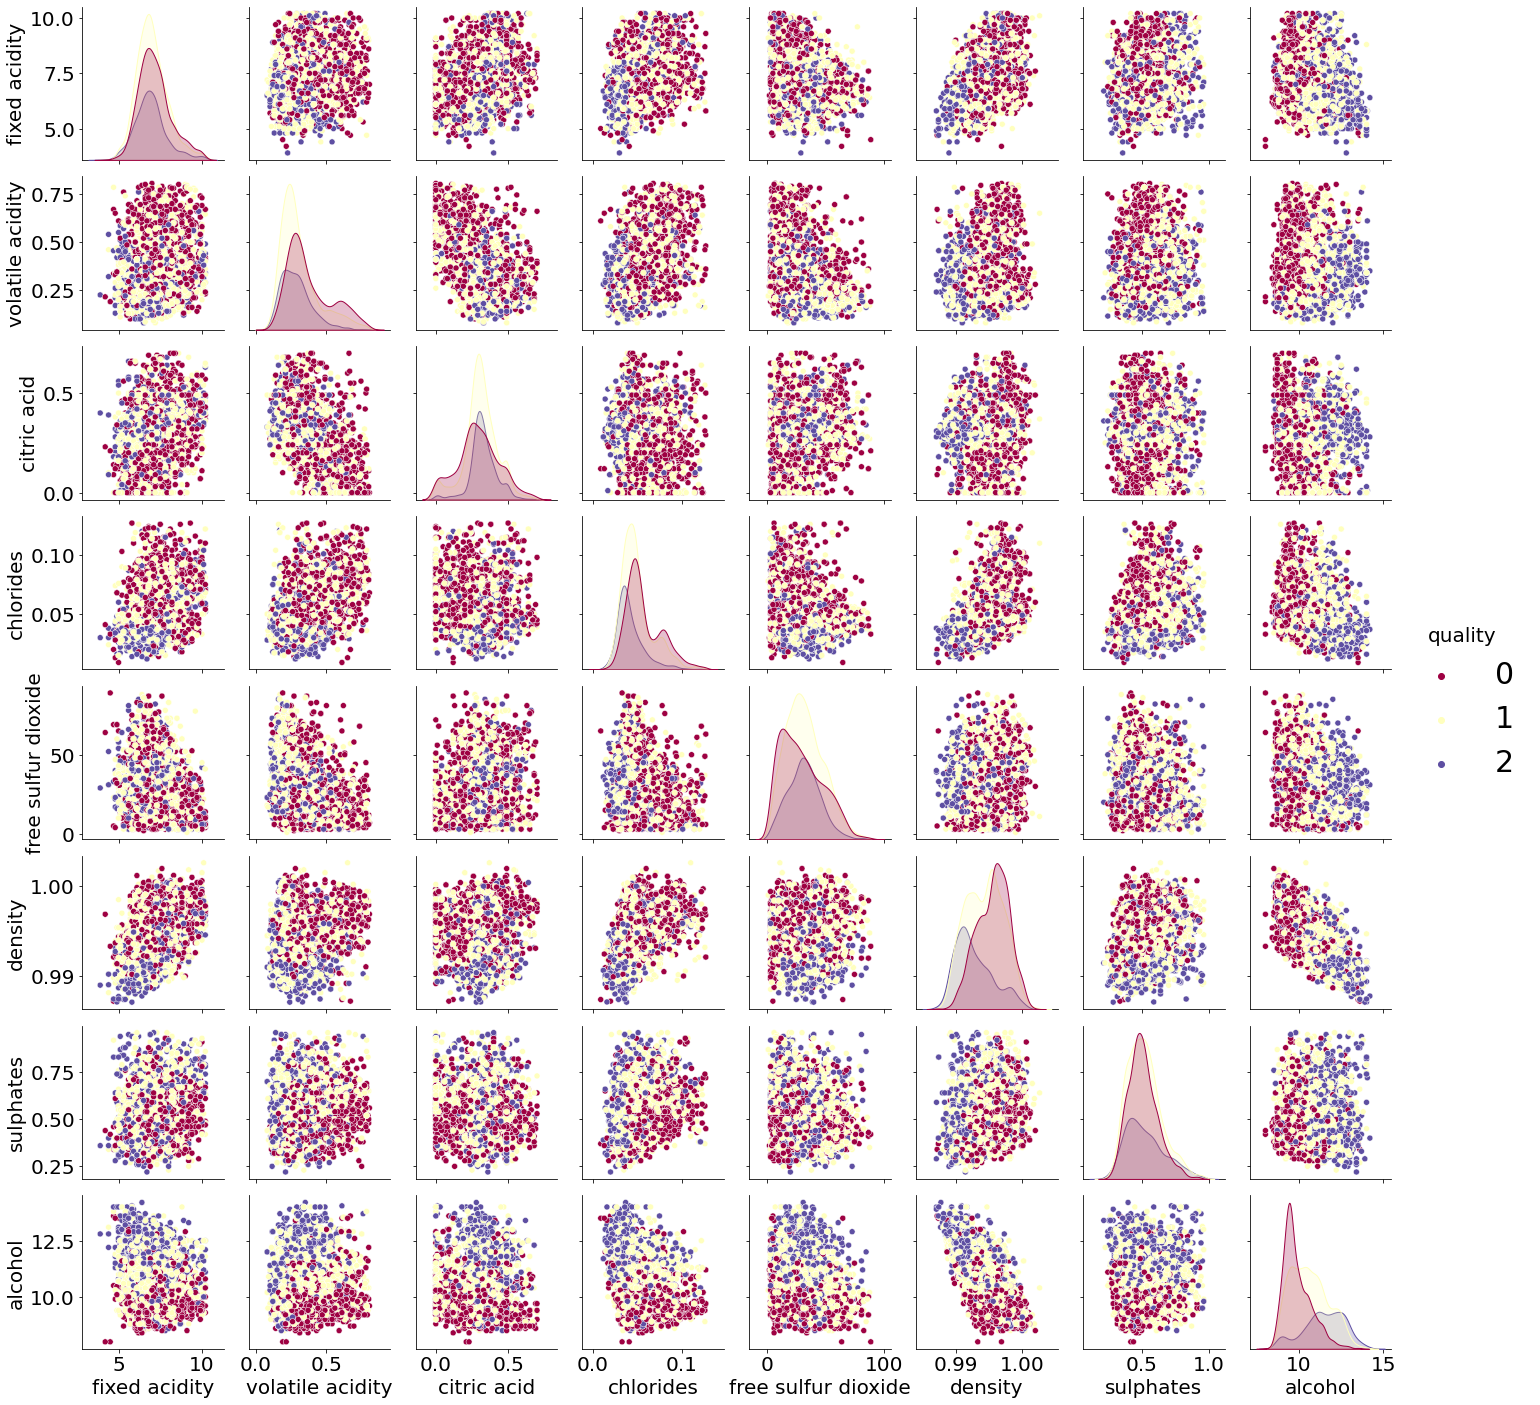

In [10]:
sns.pairplot(data1, hue='quality', palette="Spectral")

Разделим данные на тренирвочные и тестовые:

In [11]:
df_train = data1[0: len(data1) * 8 // 10]
df_test = data1[0: len(data1) * 2 // 10]

label_train = df_train['quality'].to_numpy()
label_test = df_test['quality'].to_numpy()

In [12]:
data_train = df_train.drop(columns=['quality']).to_numpy()[:,1:]
data_test = df_test.drop(columns=['quality']).to_numpy()[:,1:]

data_train.astype(np.float32)
data_test.astype(np.float32)
label_train.astype(np.float32)
label_test.astype(np.float32)
len(data_train)

print(data1.groupby("quality").size())

quality
0    2084
1    2556
2    1192
dtype: int64


Так как в ходе реализацией точность некоторых алгоритмов для разделения на больше чем два класса была очень низкой, попробуем насильно разделить данные на два отличающихся класса:

In [13]:
data2 = data1.drop(data1[data1['quality'] == 1].index)
cond = data2['quality'] == 2
data2.loc[cond, 'quality'] = 1

df_train = data2[0: len(data1) * 8 // 10]
df_test = data2[0: len(data1) * 2 // 10]

label_train2 = df_train['quality'].to_numpy()
label_test2 = df_test['quality'].to_numpy()

data_train2 = df_train.drop(columns=['quality']).to_numpy()[:,1:]
data_test2 = df_test.drop(columns=['quality']).to_numpy()[:,1:]

data_train2.astype(np.float32)
data_test2.astype(np.float32)
label_train2.astype(np.float32)
label_test2.astype(np.float32)
len(data_train2)

print(data2.groupby("quality").size())

quality
0    2084
1    1192
dtype: int64


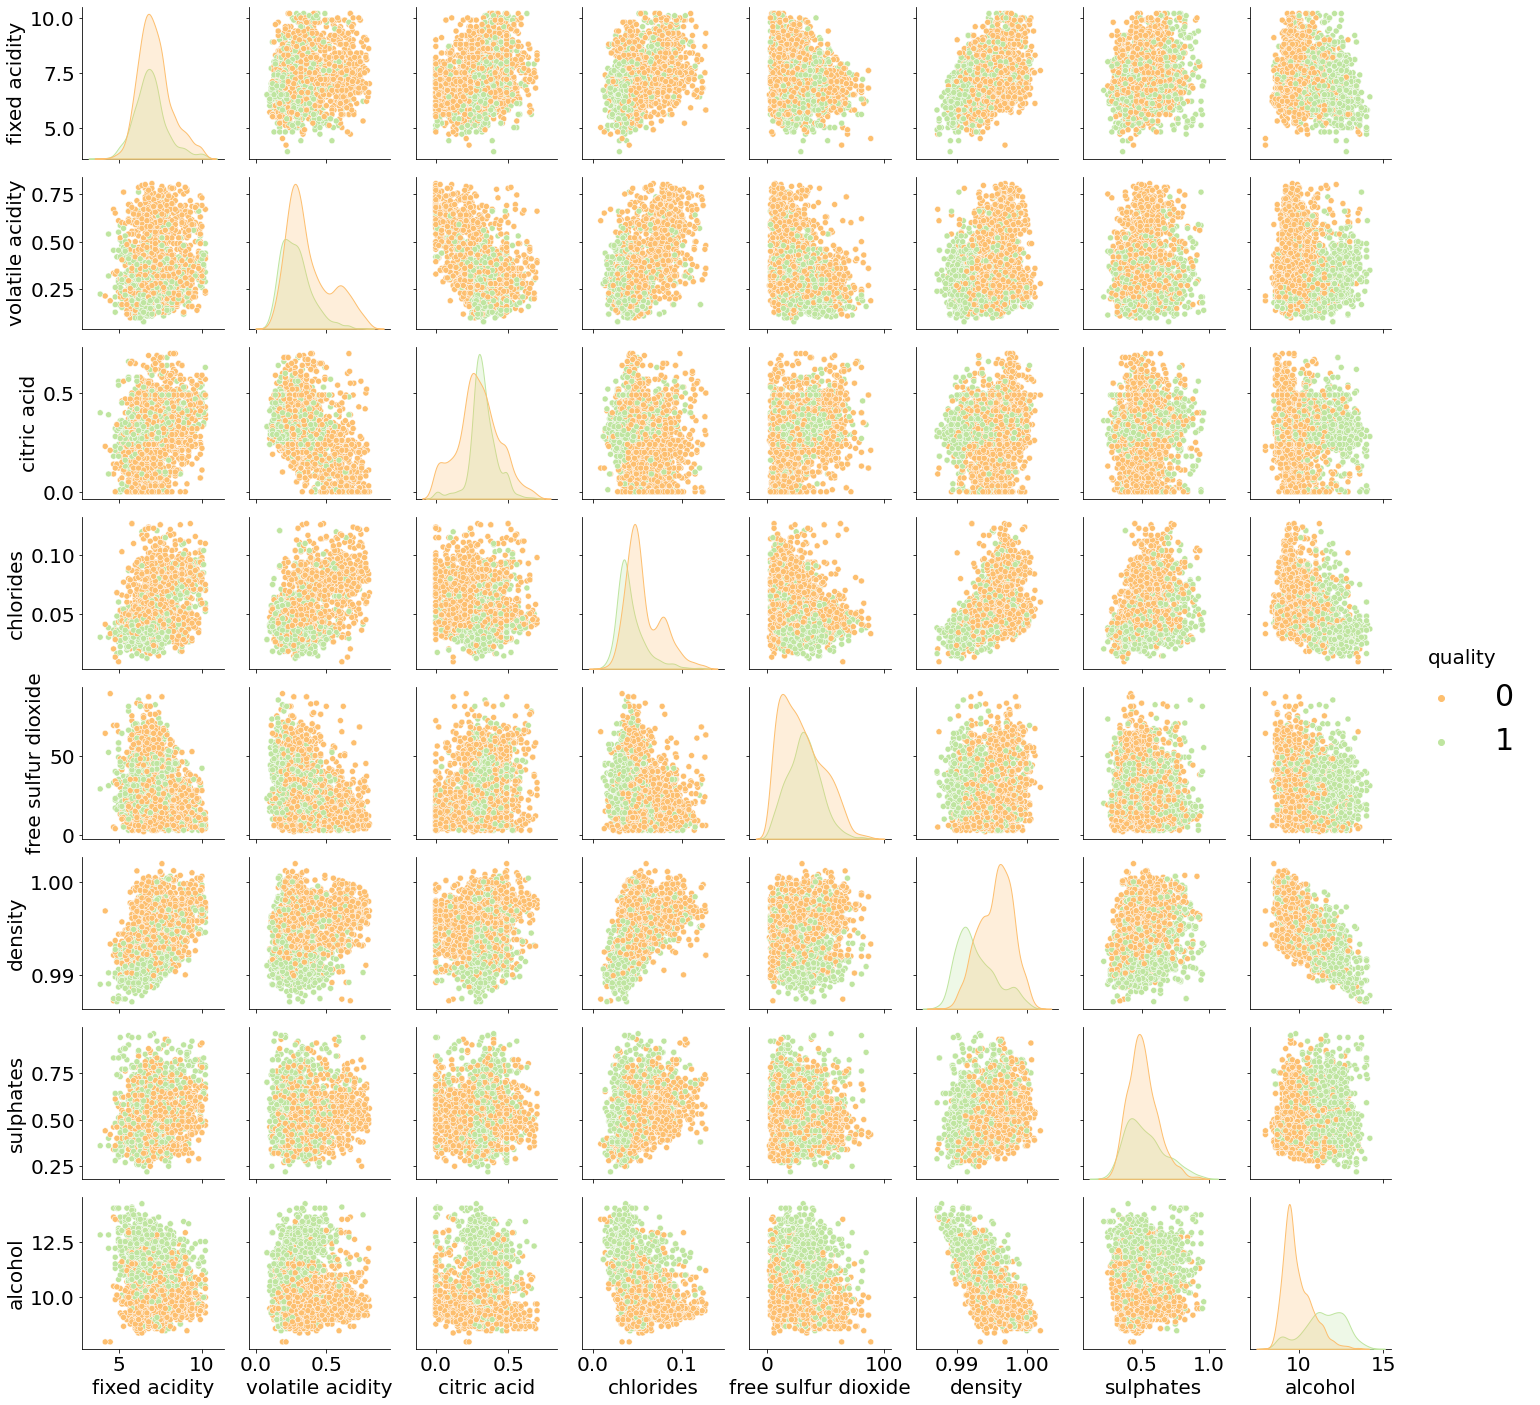

In [14]:
sns.pairplot(data2, hue='quality', palette="Spectral")

Вспомогательные функции:

In [15]:
from sklearn import metrics
def plot_ConfusionMatrix(y_true, y_pred, title = ""):
    c_matr = metrics.confusion_matrix(y_true, y_pred) 
    disp = metrics.ConfusionMatrixDisplay(c_matr)
    fig, ax = plt.subplots(figsize=(10,10));
    disp.plot(ax=ax);
    disp.ax_.set_title("ConfusionMatrix " + title);

In [16]:
def Metrics(label_test, p_labels):
    print(f"Accuracy: {metrics.accuracy_score(label_test, p_labels)}")
    print(f"Recall: {metrics.recall_score(label_test, p_labels, average = 'macro')}")
    print(f"Precision: {metrics.precision_score(label_test, p_labels, average = 'macro')}")
    

<h2> Logistic Regression (Multiclass) </h2>

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin

def one_hot(x):
    oh = []
    for i in x:
        if i == 0:
            oh.append([1.0, 0, 0])
        elif i == 1:
            oh.append([0, 1.0, 0])
        else:
            oh.append([0, 0, 1.0]) 
    return oh

class CrossEntropyLoss:
    def Loss(self, probabilities, trueVal):
        self.p = probabilities;
        self.trueVal = trueVal
        self.size = len(self.trueVal)
        self.loss = [-np.log(probabilities[i, trueVal[i]]) for i in range(self.size)]
        return self.loss
    def Back(self):
        delta = np.zeros_like(self.p)
        delta[np.arange(self.size), self.trueVal] = 1.0
        return delta / (self.p * -self.size)

class Softmax:
    def Next(self, z):
        self.z = z
        e = np.exp(z - z.max(axis=1,keepdims=True))
        sum = e.sum(axis=1,keepdims=True)
        self.p = e / sum
        return self.p
    def Back(self, dp):
        back_z = self.p
        return self.p * dp - self.p * (self.p * dp).sum(axis=1, keepdims=True)

class LogisticRegressionMulti(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, countClasses):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.softmax = Softmax()
        self.loss = CrossEntropyLoss()
        self.countClasses = countClasses

    def Forward(self, x):
        self.data = x
        p = np.dot(self.data, self.W) + self.b
        return self.softmax.Next(p.astype(np.float64))
    
    def Update(self):
        self.W -= self.lr * self.dW
        self.b -= self.lr * self.db
        
    def fit(self, data, labels): 
        self.W = np.random.normal(0.1, 1.0 / np.sqrt(len(data[0])), (len(data[0]), self.countClasses))
        self.b = np.zeros((1, self.countClasses))

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]
                
                y_hat = self.Forward(x.astype(np.float64))
                
                self.loss.Loss(y_hat, y)

                dp = self.loss.Back()
                dz = self.softmax.Back(dp)

                self.dW = np.dot(dz.T, self.data).T
                self.db = dz.sum(axis = 0)
                self.Update()
        
    def predict(self, data):
        p = self.Forward(data)
        return np.argmax(p, axis = 1)

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def Forward(self, x):
        self.data = x
        p = np.dot(self.W, self.data.T)
        return self.sigmoid(p.astype(np.float64))
    
    def Update(self):
        self.W -= self.lr * self.dW
        
    def fit(self, data, labels): 
        self.W = np.random.normal(0.1, 1.0 / np.sqrt(len(data[0])), (len(data[0]), ))

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]
                
                y_hat = self.Forward(x.astype(np.float64))

                self.dW = self.W + np.dot(y_hat - y, x)
                self.Update()
        
    def predict(self, data):
        p = self.Forward(data)
        return (p  > 0.5).astype('int64')

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'LR', 'transformer__copy', 'transformer__with_mean', 'transformer__with_std', 'LR__batch_size', 'LR__countClasses', 'LR__epoch', 'LR__lr'])
Best parameters:  {'LR__batch_size': 40, 'LR__countClasses': 3, 'LR__epoch': 80, 'LR__lr': 0.01}
Accuracy: 0.5943396226415094
Recall: 0.5566800188351884
Precision: 0.5929831040542037


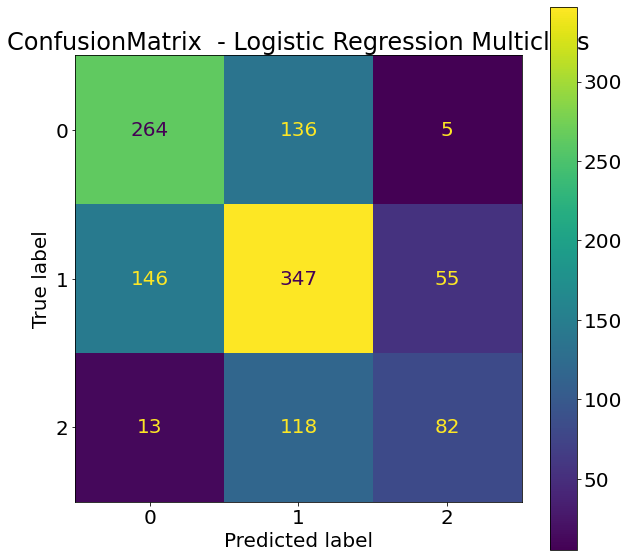

In [18]:
import os.path

lr = Pipeline(steps = [('transformer', StandardScaler()),('LR', LogisticRegressionMulti(0.01, 80, 5, 3))])
print("Параметры:", lr.get_params().keys())

if os.path.exists('LRMulti_data.pickle'):
    with open('LRMulti_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'LR__batch_size': [5, 10, 20, 40], 'LR__epoch': [20, 80], 'LR__lr': [0.01, 0.04], 'LR__countClasses':[3]}

gcv = GridSearchCV(estimator = lr, param_grid=params)
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test, p_label_test)

with open('LRMulti_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test, p_label_test, " - Logistic Regression Multiclass")


Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'LR2', 'transformer__copy', 'transformer__with_mean', 'transformer__with_std', 'LR2__batch_size', 'LR2__epoch', 'LR2__lr'])
Best parameters:  {'LR2__batch_size': 50, 'LR2__epoch': 40, 'LR2__lr': 0.01}
Accuracy: 0.7890222984562607
Recall: 0.8094378912514875
Precision: 0.7822550199381798


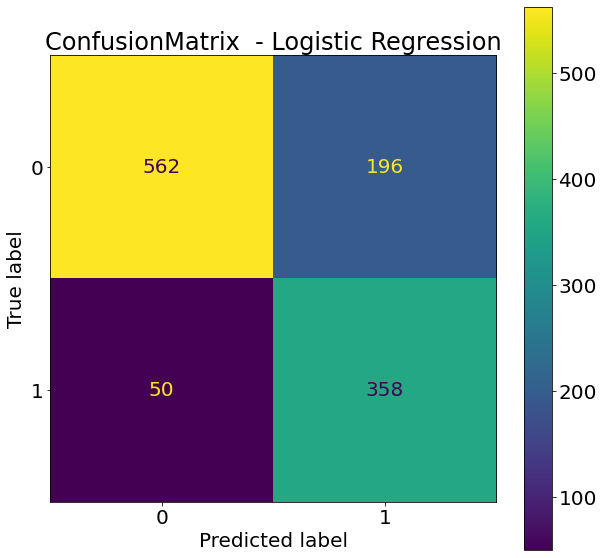

In [19]:
lr2 = Pipeline(steps = [('transformer', StandardScaler()),('LR2', LogisticRegression(0.01, 80, 5))])
print("Параметры:", lr2.get_params().keys())

if os.path.exists('LR_data.pickle'):
    with open('LR_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'LR2__batch_size': [20, 40, 50], 'LR2__epoch': [40, 80, 100], 'LR2__lr': [0.01, 0.04, 0.2]}

gcv = GridSearchCV(estimator = lr2, param_grid=params)
gcv.fit(data_train2, label_train2)

p_label_test = gcv.best_estimator_.predict(data_test2)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test2, p_label_test)

with open('LR_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test2, p_label_test, " - Logistic Regression")

<h2> SVM (Multiclass)</h2>

In [20]:
def convert(data, cond):
    x = data
    if cond == 1:
        x = np.where(x == 1, -1, x)
        x = np.where(x == 0, 1, x)
        x = np.where(x == 2, -1, x)
    elif cond == 2:
        x = np.where(x == 0, -1, x)
        x = np.where(x == 1, 1, x)
        x = np.where(x == 2, -1, x)
    else:
        x = np.where(x == 0, -1, x)
        x = np.where(x == 1, -1, x)
        x = np.where(x == 2, 1, x)
    return x.astype(np.int64)

def convert1(data):
    x = data
    x = np.where(x == 0, -1, x)
    return x.astype(np.int64)


class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, alph):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.alph = alph
    
    def Forward(self, x):
        p = np.dot(x, self.W)
        return p

    def fit(self, data, labels):
        self.W = np.ones((len(data[0]),))  

        for _ in range(self.epoch):
            for i in range(0, len(data), self.batch_size):
                x = data[i:i + self.batch_size]
                y = labels[i:i + self.batch_size]

                p = self.Forward(x)

                dp = self.alph * self.W

                for i, p_i in enumerate(p):
                    m = p_i * y[i]
                    if 1 - m > 0:
                        dp -= (x[i] * y[i]).astype(np.float64)
                        
                self.W -= self.lr * dp
        
    def predict(self, data):
        p = self.Forward(data)
        return np.sign(p).astype(np.int64)

class SVM_Multi(BaseEstimator, ClassifierMixin):
    def __init__(self, lr, epoch, batch_size, alph):
        self.lr = lr
        self.epoch = epoch
        self.batch_size = batch_size
        self.alph = alph

    def Forward(self, x):
        p = np.asarray([self.svm1.predict(x), self.svm2.predict(x), self.svm3.predict(x)]).T
        return p

    def fit(self, data, labels):
        self.svm1 = SVM(self.lr, self.epoch, self.batch_size, self.alph)
        self.svm2 = SVM(self.lr, self.epoch, self.batch_size, self.alph)
        self.svm3 = SVM(self.lr, self.epoch, self.batch_size, self.alph)

        l1 = convert(labels, 1)
        l2 = convert(labels, 2)
        l3 = convert(labels, 3)

        self.svm1.fit(data, l1)
        self.svm2.fit(data, l2)
        self.svm3.fit(data, l3)

        # acc1 = int((self.svm1.predict(data)==l1).mean() * 100)
        # acc2 = int((self.svm2.predict(data)==l2).mean() * 100)
        # acc3 = int((self.svm3.predict(data)==l3).mean() * 100)
        
        # print("acc_train svm1:" + str(acc1) + "%")
        # print("acc_train svm2:" + str(acc2) + "%")
        # print("acc_train svm3:" + str(acc3) + "%")
        
    def predict(self, data):
        p = self.Forward(data)
        rez = []
        for p_i in p:
            if p_i.tolist() == [1, 1, 1]:
                rez.append(2)
            elif p_i.tolist() == [1, 1, -1]:
                rez.append(1)
            elif p_i.tolist() == [-1, 1, 1]:
                rez.append(1)
            else:
                rez.append(np.argmax(p_i))
        return rez
        

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'SVM', 'transformer__copy', 'transformer__with_mean', 'transformer__with_std', 'SVM__alph', 'SVM__batch_size', 'SVM__epoch', 'SVM__lr'])
Best parameters:  {'SVM__alph': 0.1, 'SVM__batch_size': 10, 'SVM__epoch': 20, 'SVM__lr': 0.001}
Accuracy: 0.5231560891938251
Recall: 0.44824630097124757
Precision: 0.44912150267657686


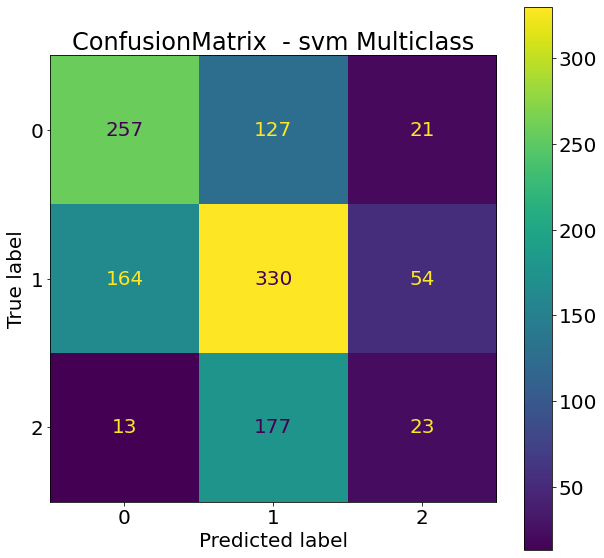

In [21]:
svm = Pipeline(steps = [('transformer', StandardScaler()),('SVM', SVM_Multi(0.05, 100, 5, 0.01))])
print("Параметры:", svm.get_params().keys())

if os.path.exists('svmMulti_data.pickle'):
    with open('svmMulti_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'SVM__alph': [0.1, 0.2], 'SVM__batch_size': [5, 10, 20], 'SVM__epoch': [20, 50], 'SVM__lr':[0.01, 0.001]}


gcv = GridSearchCV(estimator = svm, param_grid=params)
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test, p_label_test)

with open('svmMulti_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test, p_label_test, " - svm Multiclass")

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'SVM', 'transformer__copy', 'transformer__with_mean', 'transformer__with_std', 'SVM__alph', 'SVM__batch_size', 'SVM__epoch', 'SVM__lr'])
Best parameters:  {'SVM__alph': 0.1, 'SVM__batch_size': 5, 'SVM__epoch': 50, 'SVM__lr': 0.01}
Accuracy: 0.7950257289879932
Recall: 0.8157528842671633
Precision: 0.7880653944523274


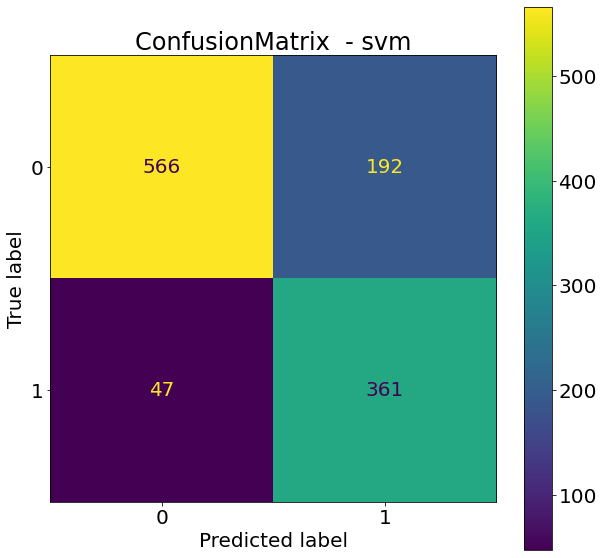

In [22]:
svm2 = Pipeline(steps = [('transformer', StandardScaler()),('SVM', SVM(0.5, 80, 5, 0.1))])
print("Параметры:", svm2.get_params().keys())

if os.path.exists('svm_data.pickle'):
    with open('svm_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'SVM__alph': [0.1, 0.05, 0.005], 'SVM__batch_size': [5, 10, 20], 'SVM__epoch': [50, 100], 'SVM__lr':[0.01, 0.1]}

gcv = GridSearchCV(estimator = svm2, param_grid=params)
gcv.fit(data_train2, convert1(label_train2))

p_label_test = gcv.best_estimator_.predict(data_test2)
print("Best parameters: ", gcv.best_params_)

Metrics(convert1(label_test2), p_label_test)

with open('svm_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(convert1(label_test2), p_label_test, " - svm")

<h2>KNN </h2>

In [23]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k, countClasses):
        self.k = k
        self.countClasses = countClasses
        
    
    def dist (self, a, b):
        return math.sqrt(np.sum(np.power(a - b, 2)))
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        

    def predict(self, data):
        predLables = []
        
        for i, d_i in enumerate(data):
            distance = list()
            for j, d_j in enumerate(self.data):
                distance.append([self.dist(d_j, d_i), self.labels[j]])

            stat_classes = np.zeros(self.countClasses)
            sort_dist = sorted(distance)
            for d in sort_dist[0:self.k]:
                stat_classes[d[1]] += 1
            
            predLables.append(np.argmax(stat_classes))

        return predLables
        

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'KNN', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'KNN__countClasses', 'KNN__k'])
Best parameters:  {'KNN__countClasses': 3, 'KNN__k': 10}
Accuracy: 0.6535162950257289
Recall: 0.6314512952576532
Precision: 0.6493313949086064


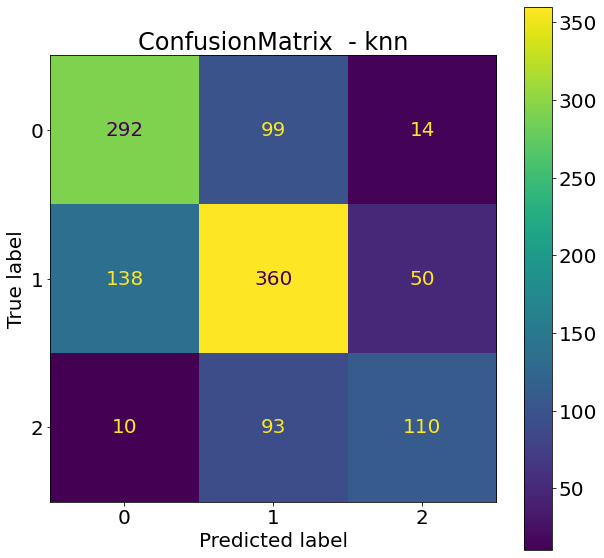

In [33]:
knn = Pipeline(steps = [('transformer', QuantileTransformer()),('KNN', KNN(3, 3))])
print("Параметры:", knn.get_params().keys())

if os.path.exists('knn_data.pickle'):
    with open('knn_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'KNN__countClasses': [3], 'KNN__k':[5, 10, 20]}

gcv = GridSearchCV(estimator = knn, param_grid=params)
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test, p_label_test)

with open('knn_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test, p_label_test, " - knn")

<h2> Bayes </h2>

In [25]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, lambd, countClasses):
        self.lambd = lambd
        self.countClasses = countClasses

    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels

        prior_p_classes = np.zeros(self.countClasses)
        for i in range(len(prior_p_classes)):
            prior_p_classes[i] = np.sum(self.labels == i) / len(self.labels)
        
        self.prior = prior_p_classes

        sum_xi = np.zeros(( self.countClasses, len(self.data[0])))
        count_xi = np.zeros(( self.countClasses, len(self.data[0])))

        for i, x in enumerate(self.data.T):
            for j in range(len(x)):
                sum_xi[self.labels[j]][i] += x[j]
                count_xi[self.labels[j]][i] += 1
        self.mean = sum_xi / count_xi

        disp = np.zeros((self.countClasses, len(self.data[0])))
        for i, x in enumerate(self.data.T):
            for j in range(len(x)):
                disp[self.labels[j]][i] += (x[j] - self.mean[self.labels[j]][i])**2
        self.disp = disp / (count_xi - np.ones_like(count_xi))

    def pr(self, x, ind_class):
        rez = 1
        for i, x_i in enumerate(x):
            rez *= 1 / (math.sqrt(2 * math.pi) * self.disp[ind_class][i])
            rez *=  math.exp(- (x_i - self.mean[ind_class][i])**2 / (2 * self.disp[ind_class][i]**2))
        return rez

    def predict(self, data):
        predLables = []
        for x in data:
            pr = self.prior * self.lambd
            for i in range(len(pr)):
                pr[i] *= self.pr(x, i)
            predLables.append(np.argmax(pr))
        

        return predLables

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'Bayes', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'Bayes__countClasses', 'Bayes__lambd'])
Best parameters:  {'Bayes__countClasses': 3, 'Bayes__lambd': 1}
Accuracy: 0.5025728987993139
Recall: 0.5320874693959922
Precision: 0.49268957052010287


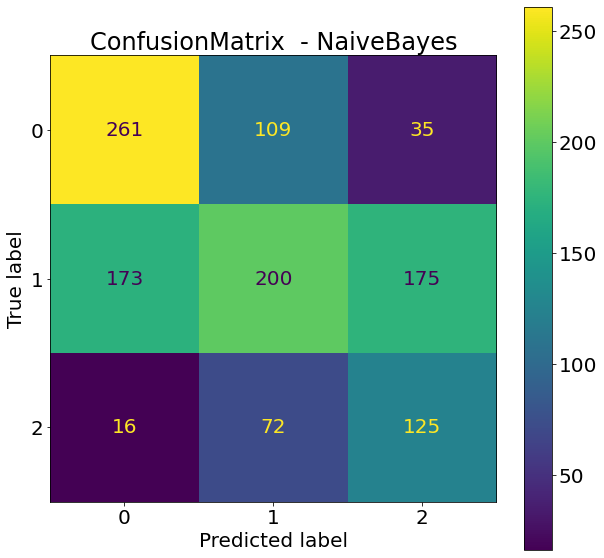

In [26]:
nb = Pipeline(steps = [('transformer', QuantileTransformer()),('Bayes', NaiveBayes(1, 3))])
print("Параметры:", nb.get_params().keys())

if os.path.exists('Bayes_data.pickle'):
    with open('Bayes_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'Bayes__countClasses' : [3], 'Bayes__lambd': [1, 2]}

gcv = GridSearchCV(estimator = nb, param_grid=params)
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test, p_label_test)

with open('Bayes_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test, p_label_test, " - NaiveBayes")

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'Bayes', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'Bayes__countClasses', 'Bayes__lambd'])
Best parameters:  {'Bayes__countClasses': 2, 'Bayes__lambd': 1}
Accuracy: 0.8036020583190394
Recall: 0.7985830875885974
Precision: 0.7845525448903434


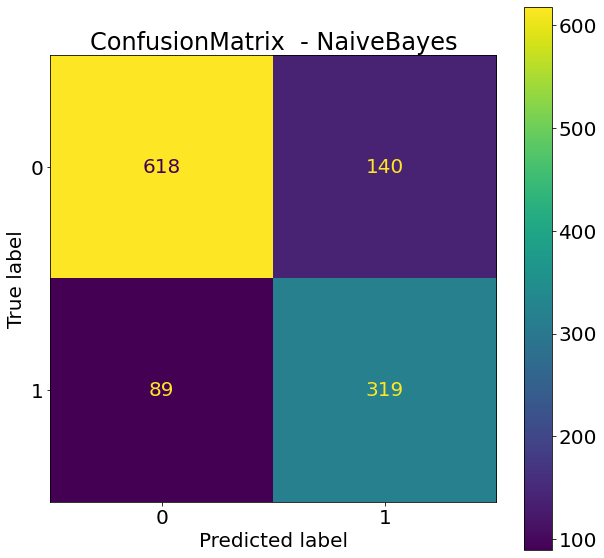

In [27]:
nb2 = Pipeline(steps = [('transformer', QuantileTransformer()),('Bayes', NaiveBayes(1, 3))])
print("Параметры:", nb2.get_params().keys())

if os.path.exists('Bayes2_data.pickle'):
    with open('Bayes2_data.pickle', 'rb') as f:
        params = pickle.load(f)
        params = {n: [val] for n, val in params.items()}
else:
    params = {'Bayes__countClasses' : [2], 'Bayes__lambd': [1, 2]}

gcv = GridSearchCV(estimator = nb2, param_grid=params)
gcv.fit(data_train2, label_train2)

p_label_test = gcv.best_estimator_.predict(data_test2)
print("Best parameters: ", gcv.best_params_)

Metrics(label_test2, p_label_test)

with open('Bayes2_data.pickle', 'wb') as f:
    pickle.dump(gcv.best_params_, f)

plot_ConfusionMatrix(label_test2, p_label_test, " - NaiveBayes")

<h2> Sklearn </h2>

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'LR', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'LR__C', 'LR__class_weight', 'LR__dual', 'LR__fit_intercept', 'LR__intercept_scaling', 'LR__l1_ratio', 'LR__max_iter', 'LR__multi_class', 'LR__n_jobs', 'LR__penalty', 'LR__random_state', 'LR__solver', 'LR__tol', 'LR__verbose', 'LR__warm_start'])
Accuracy: 0.6054888507718696
Recall: 0.5614051888151473
Precision: 0.6048570864531776


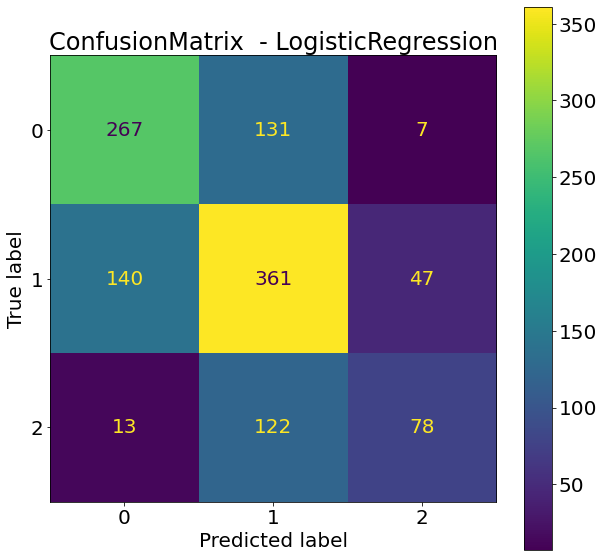

In [28]:
from sklearn.linear_model import LogisticRegression

_lr = Pipeline(steps = [('transformer', QuantileTransformer()),('LR', LogisticRegression())])

print("Параметры:", _lr.get_params().keys())

gcv = GridSearchCV(estimator = _lr, param_grid={'LR__multi_class' : ['multinomial']})
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)

Metrics(label_test, p_label_test)

plot_ConfusionMatrix(label_test, p_label_test, " - LogisticRegression")

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'svm', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'svm__C', 'svm__break_ties', 'svm__cache_size', 'svm__class_weight', 'svm__coef0', 'svm__decision_function_shape', 'svm__degree', 'svm__gamma', 'svm__kernel', 'svm__max_iter', 'svm__probability', 'svm__random_state', 'svm__shrinking', 'svm__tol', 'svm__verbose'])
Accuracy: 0.6543739279588336
Recall: 0.6093921674893311
Precision: 0.6720305888089099


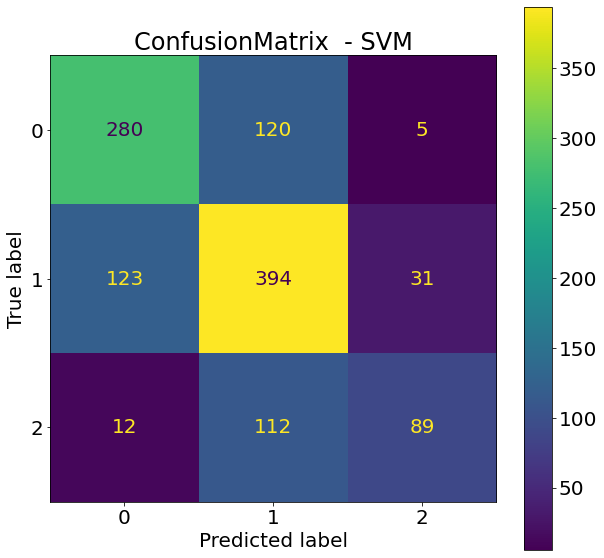

In [29]:
from sklearn import svm

_svm = Pipeline(steps = [('transformer', QuantileTransformer()),('svm', svm.SVC())])

print("Параметры:", _svm.get_params().keys())

gcv = GridSearchCV(estimator = _svm, param_grid={})
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)

Metrics(label_test, p_label_test)

plot_ConfusionMatrix(label_test, p_label_test, " - SVM")

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'knn', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])
Accuracy: 0.7512864493996569
Recall: 0.7290458530220704
Precision: 0.7471792571277377


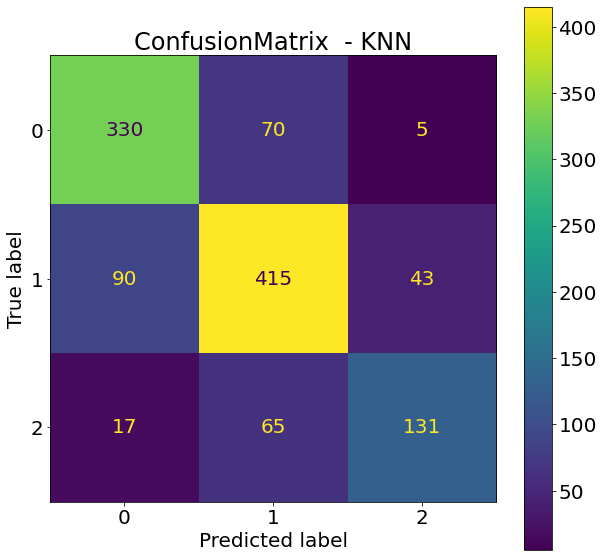

In [30]:
from sklearn.neighbors import KNeighborsClassifier

_knn = Pipeline(steps = [('transformer', QuantileTransformer()),('knn', KNeighborsClassifier())])

print("Параметры:", _knn.get_params().keys())

gcv = GridSearchCV(estimator = _knn, param_grid={})
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)

Metrics(label_test, p_label_test)

plot_ConfusionMatrix(label_test, p_label_test, " - KNN")

Параметры: dict_keys(['memory', 'steps', 'verbose', 'transformer', 'naive_bayes', 'transformer__copy', 'transformer__ignore_implicit_zeros', 'transformer__n_quantiles', 'transformer__output_distribution', 'transformer__random_state', 'transformer__subsample', 'naive_bayes__priors', 'naive_bayes__var_smoothing'])
Accuracy: 0.5051457975986278
Recall: 0.5233109147208505
Precision: 0.4908810517902718


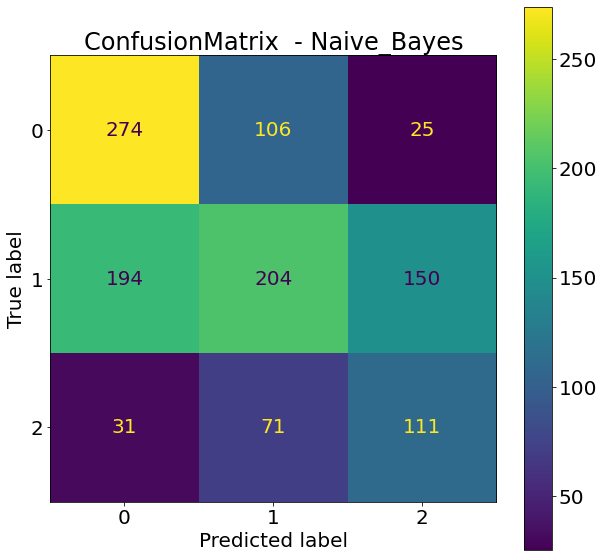

In [32]:
from sklearn import naive_bayes 

_nb = Pipeline(steps = [('transformer', QuantileTransformer()),('naive_bayes', naive_bayes.GaussianNB())])

print("Параметры:", _nb.get_params().keys())

gcv = GridSearchCV(estimator = _nb, param_grid={})
gcv.fit(data_train, label_train)

p_label_test = gcv.best_estimator_.predict(data_test)

Metrics(label_test, p_label_test)

plot_ConfusionMatrix(label_test, p_label_test, " - Naive_Bayes")